# Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eigvals, inv, pinv
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# Data Simulation

In [2]:
def simulate_poisson_data(n_samples=1000, n_features=10, multicollinearity=0.9, random_state=None):
    """
    Simulate Poisson-distributed count data with specified multicollinearity.

    Mathematical Background:
    ------------------------
    We generate predictors X ~ N(0, Σ), where Σ induces correlation (multicollinearity).
    Then, y_i ~ Poisson(λ_i), with λ_i = exp(X_i^T β).

    Parameters:
    -----------
    n_samples : int
        Number of observations.
    n_features : int
        Number of predictor variables.
    multicollinearity : float in (0, 1)
        Higher => stronger collinearity among predictors.
    random_state : int or None
        Seed for reproducibility.

    Returns:
    --------
    X_df : pd.DataFrame
        Predictor matrix of shape (n_samples, n_features).
    y_series : pd.Series
        Poisson-distributed response variable of length n_samples.
    true_beta : np.ndarray
        True regression coefficients used for generating data.
    """
    np.random.seed(random_state)

    # Construct covariance matrix for correlation
    cov = (multicollinearity - 1) * np.eye(n_features) + np.ones((n_features, n_features))
    cov /= (1 + (n_features - 1) * multicollinearity)

    # Generate correlated predictors
    X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=cov, size=n_samples)

    # Generate true coefficients from Uniform(0.5, 1.5)
    true_beta = np.random.uniform(0.5, 1.5, size=n_features)

    # Poisson mean: log(λ_i) = X_i^T β
    log_lambda = X @ true_beta
    lambda_ = np.exp(log_lambda)

    # Poisson response
    y = np.random.poisson(lam=lambda_)

    # Convert to DataFrame/Series
    X_df = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(n_features)])
    y_series = pd.Series(y, name='y')

    return X_df, y_series, true_beta

# Model Implementations

## MLE

In [3]:
def poisson_mle(X_train, y_train):
    """
    Fit Poisson Regression via MLE (IRLS).

    Math:
    -----
    For Poisson GLM:
      y_i ~ Poisson(λ_i),
      log(λ_i) = X_i^T β.
    The MLE is found by maximizing log-likelihood with IRLS.

    Returns:
    --------
    model : statsmodels GLMResults
        Fitted Poisson model (MLE).
    """
    # Ensure alignment by resetting index
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    X_train_const = sm.add_constant(X_train)
    model = GLM(y_train, X_train_const, family=families.Poisson()).fit()
    return model

In [4]:
def predict_mle(model, X_test):
    """
    Predict using Poisson MLE:
    λ = exp(const + X β_MLE).
    """
    # Align indices
    X_test = X_test.reset_index(drop=True)
    X_test_const = sm.add_constant(X_test)
    return model.predict(X_test_const)

## PRE

In [5]:
def poisson_pre(X_train, y_train, k=1.0):
    """
    Poisson Ridge Estimator (PRE).

    Math:
    -----
    Let S = X^T W X, with W = diag(λ_hat).
    Then:
      β_PRE = (S + kI)^(-1) S β_MLE.

    k > 0 controls ridge shrinkage.

    Returns:
    --------
    beta_pre : np.ndarray
    intercept_pre : float
    """
    # Align indices
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    # MLE
    model_mle = poisson_mle(X_train, y_train)
    beta_mle = model_mle.params.drop('const').values
    intercept_mle = model_mle.params['const']

    lambda_ = model_mle.fittedvalues.values
    W = np.diag(lambda_)

    X_mat = X_train.values
    S = X_mat.T @ W @ X_mat

    p = X_train.shape[1]
    I_p = np.eye(p)
    S_plus_kI = S + k * I_p

    try:
        S_plus_kI_inv = inv(S_plus_kI)
    except np.linalg.LinAlgError:
        S_plus_kI_inv = pinv(S_plus_kI)

    W_k = S_plus_kI_inv @ S
    beta_pre = W_k @ beta_mle
    return beta_pre, intercept_mle

In [6]:
def predict_pre(beta_pre, intercept_pre, X_test):
    """
    Predict λ using PRE:
    λ = exp(intercept + X β_PRE).
    """
    X_test = X_test.reset_index(drop=True)
    log_lambda = intercept_pre + (X_test.values @ beta_pre)
    return np.exp(log_lambda)

## PLE

In [7]:
def poisson_liu(X_train, y_train, d=0.5):
    """
    Poisson Liu Estimator (PLE).

    Math:
    -----
    S = X^T W X.
      β_PLE = (S + I)^(-1)(S + dI) β_MLE,
    where d in (0,1).

    Returns:
    --------
    beta_liu : np.ndarray
    intercept_liu : float
    """
    # Align indices
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    model_mle = poisson_mle(X_train, y_train)
    beta_mle = model_mle.params.drop('const').values
    intercept_mle = model_mle.params['const']

    lambda_ = model_mle.fittedvalues.values
    W = np.diag(lambda_)
    X_mat = X_train.values
    S = X_mat.T @ W @ X_mat

    p = X_train.shape[1]
    I_p = np.eye(p)
    S_plus_I = S + I_p
    S_plus_dI = S + d * I_p

    try:
        S_plus_I_inv = inv(S_plus_I)
    except np.linalg.LinAlgError:
        S_plus_I_inv = pinv(S_plus_I)

    L_d = S_plus_I_inv @ S_plus_dI
    beta_liu = L_d @ beta_mle
    return beta_liu, intercept_mle

In [8]:
def predict_ple(beta_liu, intercept_liu, X_test):
    """
    Predict λ using PLE:
    λ = exp(intercept + X β_PLE).
    """
    X_test = X_test.reset_index(drop=True)
    log_lambda = intercept_liu + (X_test.values @ beta_liu)
    return np.exp(log_lambda)

## PJSE

In [9]:
def poisson_james_stein(X_train, y_train):
    """
    Poisson James-Stein Estimator (PJSE).

    Math:
    -----
    Let β_MLE be from MLE, S = X^T W X.
    c = (β_MLE^T β_MLE) / [β_MLE^T β_MLE + trace(S^(-1))].
    β_JS = c β_MLE.

    Returns:
    --------
    beta_jse : np.ndarray
    intercept_jse : float
    """
    # Align indices
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    model_mle = poisson_mle(X_train, y_train)
    beta_mle = model_mle.params.drop('const').values
    intercept_mle = model_mle.params['const']

    lambda_ = model_mle.fittedvalues.values
    W = np.diag(lambda_)
    X_mat = X_train.values
    S = X_mat.T @ W @ X_mat

    eigenvals = eigvals(S).real
    eigenvals = np.where(eigenvals > 1e-8, eigenvals, 1e-8)
    trace_S_inv = np.sum(1 / eigenvals)

    beta_dot = beta_mle @ beta_mle
    denom = beta_dot + trace_S_inv
    c = beta_dot / denom if denom != 0 else 1.0

    beta_jse = c * beta_mle
    return beta_jse, intercept_mle

In [10]:
def predict_pjse(beta_jse, intercept_jse, X_test):
    """
    Predict λ using PJSE:
    λ = exp(intercept + X β_JS).
    """
    X_test = X_test.reset_index(drop=True)
    log_lambda = intercept_jse + (X_test.values @ beta_jse)
    return np.exp(log_lambda)

## COMPSE

In [11]:
def poisson_comp_james_stein(X_train, y_train, nu=1.0):
    """
    Conway-Maxwell Poisson James-Stein Estimator (COMPJSE) with dispersion nu.

    Math:
    -----
    β_MLE from MLE, S = X^T W X, decompose S = Q Λ Q^T,
    α = Q^T β_MLE,
    c = [Σ_j(α_j^2 λ_j)] / [Σ_j(nu + α_j^2 λ_j)],
    β_COMPJSE = c β_MLE.

    nu > 0 is the dispersion parameter, chosen via CV.

    Returns:
    --------
    beta_compjse : np.ndarray
    intercept_compjse : float
    """
    # Align indices
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    model_mle = poisson_mle(X_train, y_train)
    beta_mle = model_mle.params.drop('const').values
    intercept_mle = model_mle.params['const']

    lambda_ = model_mle.fittedvalues.values
    W = np.diag(lambda_)
    X_mat = X_train.values
    S = X_mat.T @ W @ X_mat

    eigvals_s, eigvecs_s = np.linalg.eigh(S)
    eigvals_s = np.where(eigvals_s > 1e-8, eigvals_s, 1e-8)

    alpha = eigvecs_s.T @ beta_mle
    alpha_sq = alpha**2

    numerator = np.sum(alpha_sq * eigvals_s)
    denominator = np.sum(nu + alpha_sq * eigvals_s)
    c = numerator / denominator if denominator != 0 else 1.0

    beta_compjse = c * beta_mle
    return beta_compjse, intercept_mle

In [12]:
def predict_compjse(beta_compjse, intercept_compjse, X_test):
    """
    Predict λ using COMPJSE:
    λ = exp(intercept + X β_COMPJSE).
    """
    X_test = X_test.reset_index(drop=True)
    log_lambda = intercept_compjse + (X_test.values @ beta_compjse)
    return np.exp(log_lambda)

# Nested Cross-Validation

In [13]:
def nested_cv_for_experiment(X, y,
                             outer_splits=3,
                             inner_splits=2,
                             random_state=None,
                             k_values=[0.1, 0.5, 1.0],
                             d_values=[0.1, 0.5],
                             nu_values=[0.5, 1.0, 2.0]):
    """
    Perform nested cross-validation on a single dataset (X, y) to compare:
      1) Poisson MLE
      2) PRE (Ridge, tune k)
      3) PLE (Liu, tune d)
      4) PJSE (James-Stein, no hyperparam)
      5) COMPJSE (Conway-Maxwell Poisson James-Stein, tune nu)

    Outer loop: final performance estimation.
    Inner loop: hyperparameter tuning for k, d, nu.

    Returns:
    --------
    results : pd.DataFrame with columns:
      - OuterFold
      - Best_k_PRE
      - Best_d_PLE
      - Best_nu_COMPJSE
      - MSE_MLE
      - MSE_PRE
      - MSE_PLE
      - MSE_PJSE
      - MSE_COMPJSE
    """
    from sklearn.model_selection import KFold

    results = []
    outer_kf = KFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    fold_num = 1

    for train_idx, test_idx in outer_kf.split(X):
        # Outer train/test split
        X_train_outer = X.iloc[train_idx].reset_index(drop=True)
        X_test_outer = X.iloc[test_idx].reset_index(drop=True)
        y_train_outer = y.iloc[train_idx].reset_index(drop=True)
        y_test_outer = y.iloc[test_idx].reset_index(drop=True)

        # Scaling for outer training set
        scaler_outer = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler_outer.fit_transform(X_train_outer),
                                      columns=X_train_outer.columns)
        X_test_scaled = pd.DataFrame(scaler_outer.transform(X_test_outer),
                                     columns=X_test_outer.columns)

        # Inner KFold for hyperparams
        inner_kf = KFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
        best_k, best_d, best_nu = None, None, None
        best_mse_pre = np.inf
        best_mse_ple = np.inf
        best_mse_compjse = np.inf

        # Tune k for PRE
        for candidate_k in k_values:
            inner_mses = []
            for i_train_idx, i_val_idx in inner_kf.split(X_train_scaled):
                X_i_train = X_train_scaled.iloc[i_train_idx].reset_index(drop=True)
                y_i_train = y_train_outer.iloc[i_train_idx].reset_index(drop=True)
                X_i_val = X_train_scaled.iloc[i_val_idx].reset_index(drop=True)
                y_i_val = y_train_outer.iloc[i_val_idx].reset_index(drop=True)

                beta_pre, intercept_pre = poisson_pre(X_i_train, y_i_train, k=candidate_k)
                y_pred_pre = predict_pre(beta_pre, intercept_pre, X_i_val)
                mse_val = mean_squared_error(y_i_val, y_pred_pre)
                inner_mses.append(mse_val)

            mean_mse = np.mean(inner_mses)
            if mean_mse < best_mse_pre:
                best_mse_pre = mean_mse
                best_k = candidate_k

        # Tune d for PLE
        for candidate_d in d_values:
            inner_mses = []
            for i_train_idx, i_val_idx in inner_kf.split(X_train_scaled):
                X_i_train = X_train_scaled.iloc[i_train_idx].reset_index(drop=True)
                y_i_train = y_train_outer.iloc[i_train_idx].reset_index(drop=True)
                X_i_val = X_train_scaled.iloc[i_val_idx].reset_index(drop=True)
                y_i_val = y_train_outer.iloc[i_val_idx].reset_index(drop=True)

                beta_liu, intercept_liu = poisson_liu(X_i_train, y_i_train, d=candidate_d)
                y_pred_ple = predict_ple(beta_liu, intercept_liu, X_i_val)
                mse_val = mean_squared_error(y_i_val, y_pred_ple)
                inner_mses.append(mse_val)

            mean_mse = np.mean(inner_mses)
            if mean_mse < best_mse_ple:
                best_mse_ple = mean_mse
                best_d = candidate_d

        # Tune nu for COMPJSE
        for candidate_nu in nu_values:
            inner_mses = []
            for i_train_idx, i_val_idx in inner_kf.split(X_train_scaled):
                X_i_train = X_train_scaled.iloc[i_train_idx].reset_index(drop=True)
                y_i_train = y_train_outer.iloc[i_train_idx].reset_index(drop=True)
                X_i_val = X_train_scaled.iloc[i_val_idx].reset_index(drop=True)
                y_i_val = y_train_outer.iloc[i_val_idx].reset_index(drop=True)

                beta_cjse, intercept_cjse = poisson_comp_james_stein(X_i_train, y_i_train, nu=candidate_nu)
                y_pred_cjse = predict_compjse(beta_cjse, intercept_cjse, X_i_val)
                mse_val = mean_squared_error(y_i_val, y_pred_cjse)
                inner_mses.append(mse_val)

            mean_mse = np.mean(inner_mses)
            if mean_mse < best_mse_compjse:
                best_mse_compjse = mean_mse
                best_nu = candidate_nu

        # Final training on entire outer train
        # 1) MLE
        model_mle_out = poisson_mle(X_train_scaled, y_train_outer)
        y_pred_mle_out = predict_mle(model_mle_out, X_test_scaled)
        mse_mle_out = mean_squared_error(y_test_outer, y_pred_mle_out)

        # 2) PRE with best_k
        beta_pre_out, int_pre_out = poisson_pre(X_train_scaled, y_train_outer, k=best_k)
        y_pred_pre_out = predict_pre(beta_pre_out, int_pre_out, X_test_scaled)
        mse_pre_out = mean_squared_error(y_test_outer, y_pred_pre_out)

        # 3) PLE with best_d
        beta_liu_out, int_liu_out = poisson_liu(X_train_scaled, y_train_outer, d=best_d)
        y_pred_ple_out = predict_ple(beta_liu_out, int_liu_out, X_test_scaled)
        mse_ple_out = mean_squared_error(y_test_outer, y_pred_ple_out)

        # 4) PJSE
        beta_jse_out, int_jse_out = poisson_james_stein(X_train_scaled, y_train_outer)
        y_pred_jse_out = predict_pjse(beta_jse_out, int_jse_out, X_test_scaled)
        mse_jse_out = mean_squared_error(y_test_outer, y_pred_jse_out)

        # 5) COMPJSE with best_nu
        beta_cjse_out, int_cjse_out = poisson_comp_james_stein(X_train_scaled, y_train_outer, nu=best_nu)
        y_pred_cjse_out = predict_compjse(beta_cjse_out, int_cjse_out, X_test_scaled)
        mse_cjse_out = mean_squared_error(y_test_outer, y_pred_cjse_out)

        results.append({
            'OuterFold': fold_num,
            'Best_k_PRE': best_k,
            'Best_d_PLE': best_d,
            'Best_nu_COMPJSE': best_nu,
            'MSE_MLE': mse_mle_out,
            'MSE_PRE': mse_pre_out,
            'MSE_PLE': mse_ple_out,
            'MSE_PJSE': mse_jse_out,
            'MSE_COMPJSE': mse_cjse_out
        })
        fold_num += 1

    return pd.DataFrame(results)

# Multi-Experiment Workflow

In [14]:
def multi_experiment_workflow(n_samples_list,
                              n_features_list,
                              multicollinearity_list,
                              outer_splits=3,
                              inner_splits=2,
                              random_state=42,
                              k_values=[0.1, 0.5, 1.0],
                              d_values=[0.1, 0.5],
                              nu_values=[0.5, 1.0, 2.0]):
    """
    Conduct multiple nested cross-validation experiments by iterating over:
      - n_samples_list (sample sizes)
      - n_features_list (# features)
      - multicollinearity_list (corr. levels)

    For each combination (ns, nf, mc):
      1. Simulate Poisson data (simulate_poisson_data).
      2. Run nested_cv_for_experiment with outer/inner CV.
      3. Collect final MSE results for five models:
         MLE, PRE, PLE, PJSE, COMPJSE.

    Parameters:
    -----------
    n_samples_list : list of int
        Various sample sizes to evaluate.
    n_features_list : list of int
        Various feature counts to evaluate.
    multicollinearity_list : list of float
        Correlation levels to evaluate (0<mc<1).
    outer_splits : int
        # of outer folds in nested CV.
    inner_splits : int
        # of inner folds for hyperparam tuning.
    random_state : int or None
        Seed for reproducibility.
    k_values : list of float
        Candidate ridge parameters for PRE.
    d_values : list of float
        Candidate Liu parameters for PLE.
    nu_values : list of float
        Candidate dispersion parameters for COMPJSE.

    Returns:
    --------
    final_df : pd.DataFrame
      Rows for each outer fold across all experiment combos.
      Columns: n_samples, n_features, multicollinearity,
               OuterFold, Best_k_PRE, Best_d_PLE, Best_nu_COMPJSE,
               MSE_MLE, MSE_PRE, MSE_PLE, MSE_PJSE, MSE_COMPJSE.
    """
    all_results = []

    # Triple nested loop
    for ns in n_samples_list:
        for nf in n_features_list:
            for mc in multicollinearity_list:
                print(f"\n>>> Experiment: n_samples={ns}, n_features={nf}, multicollinearity={mc}")
                # Simulate data
                X_df, y_series, _ = simulate_poisson_data(n_samples=ns,
                                                         n_features=nf,
                                                         multicollinearity=mc,
                                                         random_state=random_state)

                # Nested CV
                cv_results = nested_cv_for_experiment(
                    X_df, y_series,
                    outer_splits=outer_splits,
                    inner_splits=inner_splits,
                    random_state=random_state,
                    k_values=k_values,
                    d_values=d_values,
                    nu_values=nu_values
                )

                cv_results['n_samples'] = ns
                cv_results['n_features'] = nf
                cv_results['multicollinearity'] = mc

                all_results.append(cv_results)

    final_df = pd.concat(all_results, ignore_index=True)
    return final_df

# Main Execution

>>> Starting Comprehensive Multi-Experiment Workflow...

>>> Experiment: n_samples=1000, n_features=5, multicollinearity=0.7

>>> Experiment: n_samples=1000, n_features=5, multicollinearity=0.8

>>> Experiment: n_samples=1000, n_features=5, multicollinearity=0.9

>>> Experiment: n_samples=1000, n_features=10, multicollinearity=0.7

>>> Experiment: n_samples=1000, n_features=10, multicollinearity=0.8

>>> Experiment: n_samples=1000, n_features=10, multicollinearity=0.9

>>> Experiment: n_samples=1000, n_features=20, multicollinearity=0.7

>>> Experiment: n_samples=1000, n_features=20, multicollinearity=0.8

>>> Experiment: n_samples=1000, n_features=20, multicollinearity=0.9

>>> Experiment: n_samples=5000, n_features=5, multicollinearity=0.7

>>> Experiment: n_samples=5000, n_features=5, multicollinearity=0.8

>>> Experiment: n_samples=5000, n_features=5, multicollinearity=0.9

>>> Experiment: n_samples=5000, n_features=10, multicollinearity=0.7

>>> Experiment: n_samples=5000, n_featu

,multicollinearity,MSE_MLE,MSE_PRE,MSE_PLE,MSE_PJSE,MSE_COMPJSE
0,0.7000,3882773533.3840,3882630189.8850,3882773290.5629,3292180896.4117,3882766472.6587
1,0.8000,424060817.6679,424067724.4712,424060768.6412,316634165.1046,424059427.9733
2,0.9000,38795577.4584,38820011.7134,38817568.1343,105838421.2671,38796962.5646


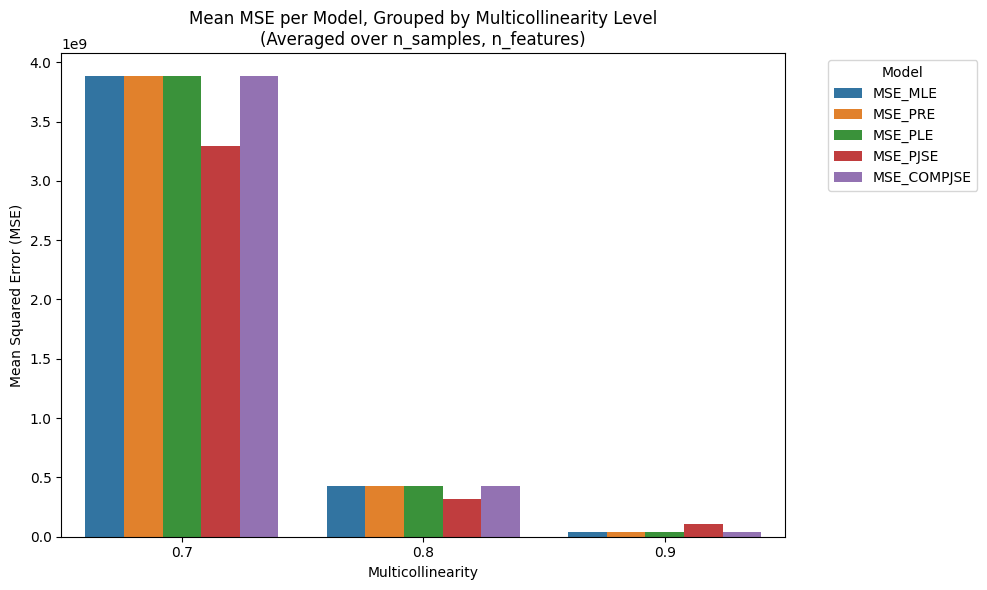

In [15]:
if __name__ == "__main__":
    n_samples_list = [1000, 5000, 10000]
    n_features_list = [5, 10, 20]
    multicollinearity_list = [0.7, 0.8, 0.9]

    outer_splits = 5
    inner_splits = 3
    random_state = 42

    # Hyperparameter grids
    k_values = [0.1, 0.5, 1.0]
    d_values = [0.1, 0.5, 1.0]
    nu_values = [0.5, 1.0, 2.0]

    print(">>> Starting Comprehensive Multi-Experiment Workflow...")

    # Run the multi-experiment workflow
    final_results_df = multi_experiment_workflow(
        n_samples_list=n_samples_list,
        n_features_list=n_features_list,
        multicollinearity_list=multicollinearity_list,
        outer_splits=outer_splits,
        inner_splits=inner_splits,
        random_state=random_state,
        k_values=k_values,
        d_values=d_values,
        nu_values=nu_values
    )

    pd.set_option('display.float_format', '{:.4f}'.format)
    print("\n=== Comprehensive Multi-Experiment Nested CV Results ===\n")
    print(final_results_df.to_string(index=False))

    # Group by only "multicollinearity" and average over n_samples and n_features
    group_cols = ['multicollinearity']
    metrics = ['MSE_MLE','MSE_PRE','MSE_PLE','MSE_PJSE','MSE_COMPJSE']

    # Summarize performance: mean MSE by each multicollinearity level,
    # aggregating across all n_samples and n_features
    summary_df = final_results_df.groupby(group_cols)[metrics].mean().reset_index()
    print("\n=== Summary of Mean MSE by Multicollinearity (averaged over n_samples, n_features) ===\n")
    display(summary_df)
    print("\n")

    # Create a grouped bar chart
    # 1) Melt the summary_df so we have columns: multicollinearity, Model, MSE
    melted_summary = summary_df.melt(
        id_vars='multicollinearity',
        value_vars=metrics,
        var_name='Model',
        value_name='MSE'
    )

    # 2) Plot grouped bar chart: x=multicollinearity, y=MSE, hue=Model
    plt.figure(figsize=(10, 6))
    sns.barplot(x='multicollinearity', y='MSE', hue='Model', data=melted_summary)
    plt.title('Mean MSE per Model, Grouped by Multicollinearity Level\n(Averaged over n_samples, n_features)')
    plt.xlabel('Multicollinearity')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()